# Tool-Calling Circuit Analysis with Qwen3-4B

This notebook investigates the circuits underlying tool-calling behavior in Qwen3-4B using attribution graphs and interventions.

## Hypothesis

**Tool delegation shares circuitry with "known answer" circuits.** When a model delegates to a tool, it may be using similar mechanisms to when it recognizes it doesn't know an answer - essentially detecting "I don't know this, but I know how to find out."

## Overview of Experiments

We will conduct three main experiments:

1. **Experiment 1: Known Answer vs Tool Use** - Compare circuits when the model knows an answer directly vs. when it delegates to a tool for the same type of question.

2. **Experiment 2: Tool Selection Circuits** - Analyze what circuits determine which tool to call when multiple tools are available.

3. **Experiment 3: Intervention Studies** - Validate our understanding by ablating or amplifying specific supernodes to change model behavior (e.g., make it use a tool when it normally wouldn't, or vice versa).

We use the circuit-tracer library to generate attribution graphs and perform targeted interventions on Qwen3-4B with transcoders.

> [!NOTE]
> **Runtime Environment**: This notebook is designed for **RunPod with A40 GPU**, not Google Colab. The setup code in Cell 1 differs from the circuit-tracer demos accordingly (uses `uv` package manager, different paths, etc.). If you're adapting this for Colab, refer to the original `circuit_tracing_tutorial.ipynb` for Colab-specific setup. Furthermore, note that since the transcoder for each layer is ~1.68GB/layer for 35 layers on top of the base model, this notebook is not designed to run on Colab. We instead allocate a disk space of 100-200GB for this notebook from Runpod.

In [7]:
#@title RunPod Environment Setup (Complete)

import os

# Install uv
!pip install uv -q

# Fix broken transformers - uninstall and reinstall
!uv pip uninstall --system transformers -q
!uv pip install --system "transformers>=4.50.0" --reinstall --no-cache -q
!uv pip install --system torchvision --reinstall -q

# Clone circuit-tracer repo
!git clone https://github.com/safety-research/circuit-tracer.git /workspace/circuit-tracer 2>/dev/null || echo "Already cloned"

# Install circuit-tracer and dependencies
!uv pip install --system -e /workspace/circuit-tracer -q

# Add demos directory to Python path
os.chdir('/workspace/circuit-tracer/demos')

print('Setup complete!')
print('RESTART THE KERNEL now, then skip this cell and run from cell 2.')
IN_COLAB = False


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Setup complete!
RESTART THE KERNEL now, then skip this cell and run from cell 2.


In [1]:
# Login to HuggingFace (required to download model weights)
# Set your token via: export HF_TOKEN=your_token_here
# Or run: huggingface-cli login

from huggingface_hub import login
import os

hf_token = os.environ.get("HF_TOKEN")
if hf_token:
    login(token=hf_token)
else:
    # Interactive login - will prompt for token
    login()

In [2]:
from collections import namedtuple
from typing import List, Dict, Union

import torch
torch.cuda.empty_cache()
from circuit_tracer import ReplacementModel

# Load Qwen3-4B with transcoders
model = ReplacementModel.from_pretrained(
    "Qwen/Qwen3-4B",
    "mwhanna/qwen3-4b-transcoders",
    dtype=torch.bfloat16
)

print(f"Model loaded: {model.cfg.model_name}")
print(f"Vocab size: {model.tokenizer.vocab_size}")

config.yaml:   0%|          | 0.00/127 [00:00<?, ?B/s]

Fetching 36 files:   0%|          | 0/36 [00:00<?, ?it/s]

layer_0.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_15.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_12.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_14.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_10.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_1.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_13.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_11.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_16.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_17.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_18.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_19.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_2.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_20.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_21.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_22.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_23.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_24.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_25.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_26.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_27.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_28.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_29.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_3.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_30.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_31.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_32.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_33.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_34.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_35.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_4.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_5.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_6.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_7.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_8.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

layer_9.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-4B into HookedTransformer
Model loaded: Qwen3-4B
Vocab size: 151643


In [3]:
def format_chat(system_prompt: str, user_message: str, assistant_prefix: str = "") -> str:
    """Format messages using Qwen3-4B chat template.
    
    NOTE: Unlike Gemma, Qwen3 has NO BOS token, so we don't strip the first 5 chars.
    
    Args:
        system_prompt: The system message (instructions, tool definitions)
        user_message: The user's query
        assistant_prefix: Optional prefix for assistant response
    
    Returns:
        Formatted prompt string ready for the model
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_message},
    ]
    formatted = model.tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False  # Disable <think> tags for cleaner circuit analysis
    )
    if assistant_prefix:
        formatted += assistant_prefix
    return formatted


# Test the format_chat function
test_prompt = format_chat(
    "You are a helpful assistant.",
    "What is the capital of France? Answer in one word."
)
print("Formatted prompt example:")
print(repr(test_prompt))

Formatted prompt example:
'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nWhat is the capital of France? Answer in one word.<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'


In [4]:
def get_top_outputs(logits: torch.Tensor, k: int = 5) -> list[tuple[str, float]]:
    """Extract top-k predicted tokens with their probabilities.
    
    Args:
        logits: Model output logits tensor of shape (batch, seq_len, vocab_size)
        k: Number of top predictions to return
    
    Returns:
        List of (token_string, probability) tuples
    """
    # Get probabilities from the last position
    top_probs, top_token_ids = logits.squeeze(0)[-1].softmax(-1).topk(k)
    top_tokens = [model.tokenizer.decode(token_id) for token_id in top_token_ids]
    top_outputs = list(zip(top_tokens, top_probs.tolist()))
    return top_outputs


def display_predictions(prompt_id: str, logits: torch.Tensor, k: int = 5, full_response: str = None):
    """Display formatted predictions for a prompt.
    
    Args:
        prompt_id: Identifier/name for the prompt being analyzed
        logits: Model output logits tensor
        k: Number of top predictions to display
        full_response: Optional full generated response to display
    """
    top_outputs = get_top_outputs(logits, k)
    
    print(f"\n{'='*50}")
    print(f"Predictions for: {prompt_id}")
    print(f"{'='*50}")
    
    for i, (token, prob) in enumerate(top_outputs, 1):
        # Handle special characters in display
        display_token = repr(token) if token.strip() == '' else token
        print(f"  {i}. {display_token:20s} ({prob*100:.2f}%)")
    
    if full_response:
        print(f"\n  Full Response: {full_response}")
    
    return top_outputs


def generate_full_response(prompt: str, max_new_tokens: int = 30) -> str:
    """Generate the full assistant response for a prompt.
    
    Args:
        prompt: The formatted prompt string
        max_new_tokens: Maximum tokens to generate
        
    Returns:
        The generated text (assistant's full response)
    """
    input_ids = model.tokenizer.encode(prompt, return_tensors="pt").to(model.cfg.device)
    
    with torch.no_grad():
        generated = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            stop_at_eos=True
        )
    
    # Decode only the new tokens (the response)
    response = model.tokenizer.decode(generated[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()


# Example usage with test_prompt from above
test_logits, test_activations = model.get_activations(test_prompt)

# Test generate_full_response
print('\nExample: Testing generate_full_response on test_prompt')
test_full_response = generate_full_response(test_prompt)

# Display predictions for the test prompt (with full response)
print('\nExample: Running display_predictions on test_prompt')
test_top_outputs = display_predictions('Test: Capital of France', test_logits, full_response=test_full_response)

# Also show raw get_top_outputs result
print('\n\nRaw get_top_outputs result:')
print(get_top_outputs(test_logits, k=5))


Example: Testing generate_full_response on test_prompt


  0%|          | 0/30 [00:00<?, ?it/s]


Example: Running display_predictions on test_prompt

Predictions for: Test: Capital of France
  1. Paris                (100.00%)
  2. Par                  (0.00%)
  3. 巴黎                   (0.00%)
  4. PAR                  (0.00%)
  5. France               (0.00%)

  Full Response: Paris


Raw get_top_outputs result:
[('Paris', 1.0), ('Par', 6.139278411865234e-06), ('巴黎', 2.562999725341797e-06), ('PAR', 9.424984455108643e-07), ('France', 7.338821887969971e-07)]


In [5]:
# Add notebook directory to path for local module imports
import sys
import os

# Add paths for both local development and RunPod environments
notebook_dir = os.getcwd()
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)
    
# RunPod workspace path
if '/workspace/circuit-tracer/demos' not in sys.path:
    sys.path.insert(0, '/workspace/circuit-tracer/demos')

# Local development path
if '/home/hktan/Tool-Calling-Interpretability/circuit-tracer/demos' not in sys.path:
    sys.path.insert(0, '/home/hktan/Tool-Calling-Interpretability/circuit-tracer/demos')

from graph_visualization import Supernode, InterventionGraph, Feature, create_graph_visualization

print("Visualization classes imported successfully:")
print(f"  - Supernode: {Supernode}")
print(f"  - InterventionGraph: {InterventionGraph}")
print(f"  - Feature: {Feature}")
print(f"  - create_graph_visualization: {create_graph_visualization}")

Visualization classes imported successfully:
  - Supernode: <class 'graph_visualization.Supernode'>
  - InterventionGraph: <class 'graph_visualization.InterventionGraph'>
  - Feature: <class 'graph_visualization.Feature'>
  - create_graph_visualization: <function create_graph_visualization at 0x7da7f5f8d080>


In [6]:
# An Intervention says "set the activation of supernode to scaling_factor * its default activation"
Intervention = namedtuple('Intervention', ['supernode', 'scaling_factor'])


def supernode_intervention(
    intervention_graph: InterventionGraph, 
    interventions: List[Intervention], 
    replacements: Dict[str, Supernode] = None,
    verbose: bool = True
):
    """Performs interventions on a set of supernodes, records the outputs, and draws the graph.

    Args:
        intervention_graph: The InterventionGraph containing supernodes and prompt
        interventions: List of Intervention namedtuples specifying (supernode, scaling_factor)
        replacements: Optional dict mapping node names to replacement Supernode objects
            for visualizing node substitutions (e.g., swapping Texas -> California)
        verbose: If True, print top 5 outputs with probabilities for easy table population

    Returns:
        IPython.display.SVG: An SVG visualization showing the graph with interventions applied
    
    Example:
        # Ablate the "Texas" supernode (set to 0x its original value)
        supernode_intervention(graph, [Intervention(texas_node, 0)])
        
        # Amplify "California" and ablate "Texas"
        supernode_intervention(graph, [
            Intervention(texas_node, -2),
            Intervention(california_node, 2)
        ], replacements={texas_node.name: california_node})
    """
    # Build intervention values: (layer, position, feature_idx, new_activation_value)
    intervention_values = [
        (*feature, scaling_factor * default_act) 
        for intervened_supernode, scaling_factor in interventions 
        for feature, default_act in zip(
            intervened_supernode.features, 
            intervened_supernode.default_activations
        )
    ]
    
    # Apply interventions and get new model outputs
    new_logits, new_activations = model.feature_intervention(
        intervention_graph.prompt, 
        intervention_values
    )
    
    # Update activation fractions for all nodes
    intervention_graph.set_node_activation_fractions(new_activations)
    
    # Get top predicted tokens
    top_outputs = get_top_outputs(new_logits)

    # Print top 5 outputs for easy table population
    if verbose:
        print("\nTop 5 Outputs:")
        for i, (token, prob) in enumerate(top_outputs[:5], 1):
            display_token = repr(token) if token.strip() == '' else token
            print(f"  {i}. {display_token:20s} ({prob*100:.2f}%)")
        print()

    # Mark intervened nodes with their scaling factor
    for intervened_supernode, scaling_factor in interventions:
        intervened_supernode.activation = None
        intervened_supernode.intervention = f'{scaling_factor}x'

    # Set up replacement nodes for visualization
    if replacements is not None:
        for target, replacement in replacements.items():
            intervention_graph.nodes[target].replacement_node = replacement

    return create_graph_visualization(intervention_graph, top_outputs)


print("Intervention helper functions defined:")
print(f"  - Intervention namedtuple: {Intervention}")
print(f"  - supernode_intervention() function ready (with verbose=True default)")

Intervention helper functions defined:
  - Intervention namedtuple: <class '__main__.Intervention'>
  - supernode_intervention() function ready (with verbose=True default)


## Section 3: Experiment Definitions

This section defines the prompts for our two main experiment sets:

1. **Experiment 1**: Base case with single tool (Google) - 4 prompts testing known vs unknown entities with and without tool option
2. **Experiment 2**: Multiple tools - 8 prompts testing tool ordering effects and wrong tool scenarios

Each prompt is structured as a dictionary with:
- `system`: The system prompt with instructions
- `user`: The user query (Jordan = known entity, Batkin = unknown entity)
- `expected`: What behavior we expect from the model

In [7]:
# Experiment 1: Base Case - Single Tool (Google)
# 2x2 design: (known vs unknown entity) x (with vs without tool option)

EXP1_PROMPTS = {
    # No tool option - tests baseline behavior
    "1A_Jordan": {
        "system": "If you know the answer, you should say it in one word.",
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"  # Known entity -> direct answer
    },
    "1A_Batkin": {
        "system": "If you know the answer, you should say it in one word.",
        "user": "What sport does Michael Batkin play?",
        "expected": "Hallucinate"  # Unknown entity -> uncertain/hallucinate
    },
    # With Google tool option
    "1AG_Jordan": {
        "system": "If you know the answer, you should say it in one word. If you want to Google it, say Google.",
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"  # Known entity -> still direct answer
    },
    "1AG_Batkin": {
        "system": "If you know the answer, you should say it in one word. If you want to Google it, say Google.",
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"  # Unknown entity + tool -> delegate to tool
    },
}

print(f"Experiment 1: {len(EXP1_PROMPTS)} prompts defined")
for pid, pdata in EXP1_PROMPTS.items():
    print(f"  {pid}: Entity = {'Jordan' if 'Jordan' in pdata['user'] else 'Batkin'}, "
          f"Prompt Order = {'A (No Tool)' if 'Google' not in pdata['system'] else 'AG (With Tool)'}, "
          f"Expected = {pdata['expected']}")

Experiment 1: 4 prompts defined
  1A_Jordan: Entity = Jordan, Prompt Order = A (No Tool), Expected = Basketball
  1A_Batkin: Entity = Batkin, Prompt Order = A (No Tool), Expected = Hallucinate
  1AG_Jordan: Entity = Jordan, Prompt Order = AG (With Tool), Expected = Basketball
  1AG_Batkin: Entity = Batkin, Prompt Order = AG (With Tool), Expected = Google


In [8]:
# Experiment 2: Multiple Tools
# Tests tool ordering effects and wrong tool scenarios

# Base system prompts with different orderings (all 6 permutations of A, G, C)
# A = "If you know the answer, say it in one word."
# G = "If you want to Google it, say Google."
# C = "If you want to use a calculator, say Calculator."

ORDERING_AGC = "If you know the answer, say it in one word. If you want to Google it, say Google. If you want to use a calculator, say Calculator."
ORDERING_ACG = "If you know the answer, say it in one word. If you want to use a calculator, say Calculator. If you want to Google it, say Google."
ORDERING_CAG = "If you want to use a calculator, say Calculator. If you know the answer, say it in one word. If you want to Google it, say Google."
ORDERING_GAC = "If you want to Google it, say Google. If you know the answer, say it in one word. If you want to use a calculator, say Calculator."
ORDERING_GCA = "If you want to Google it, say Google. If you want to use a calculator, say Calculator. If you know the answer, say it in one word."
ORDERING_CGA = "If you want to use a calculator, say Calculator. If you want to Google it, say Google. If you know the answer, say it in one word."
ORDERING_AC = "If you know the answer, say it in one word. If you want to use a calculator, say Calculator."

EXP2_PROMPTS = {
    # Ordering AGC: Answer first, Google second, Calculator third
    "2AGC_Jordan": {
        "system": ORDERING_AGC,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2AGC_Batkin": {
        "system": ORDERING_AGC,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"
    },
    # Ordering ACG: Answer first, Calculator second, Google third
    "2ACG_Jordan": {
        "system": ORDERING_ACG,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2ACG_Batkin": {
        "system": ORDERING_ACG,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"  # Should still pick Google (correct tool), not Calculator
    },
    # Ordering CAG: Calculator first, Answer second, Google third
    "2CAG_Jordan": {
        "system": ORDERING_CAG,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2CAG_Batkin": {
        "system": ORDERING_CAG,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"
    },
    # Ordering GAC: Google first, Answer second, Calculator third
    "2GAC_Jordan": {
        "system": ORDERING_GAC,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2GAC_Batkin": {
        "system": ORDERING_GAC,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"
    },
    # Ordering GCA: Google first, Calculator second, Answer third
    "2GCA_Jordan": {
        "system": ORDERING_GCA,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2GCA_Batkin": {
        "system": ORDERING_GCA,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"
    },
    # Ordering CGA: Calculator first, Google second, Answer third
    "2CGA_Jordan": {
        "system": ORDERING_CGA,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"
    },
    "2CGA_Batkin": {
        "system": ORDERING_CGA,
        "user": "What sport does Michael Batkin play?",
        "expected": "Google"
    },
    # Wrong Tool Controls: Only Calculator available (no Google)
    "2AC_Jordan": {
        "system": ORDERING_AC,
        "user": "What sport does Michael Jordan play?",
        "expected": "Basketball"  # Known -> direct answer
    },
    "2AC_Batkin": {
        "system": ORDERING_AC,
        "user": "What sport does Michael Batkin play?",
        "expected": "Uncertain (Calculator/Hallucinate)"  # Unknown + wrong tool -> uncertain/hallucinate
    },
}

print(f"Experiment 2: {len(EXP2_PROMPTS)} prompts defined")
print("\nAll 6 Tool Ordering Permutations (12 prompts):")
for ordering in ["AGC", "ACG", "CAG", "GAC", "GCA", "CGA"]:
    for entity in ["Jordan", "Batkin"]:
        pid = f"2{ordering}_{entity}"
        pdata = EXP2_PROMPTS[pid]
        print(f"  {pid}: Expected = {pdata['expected']}")
print("\nWrong Tool Controls (2 prompts):")
for pid in ["2AC_Jordan", "2AC_Batkin"]:
    pdata = EXP2_PROMPTS[pid]
    print(f"  {pid}: Entity = {'Jordan' if 'Jordan' in pdata['user'] else 'Batkin'}, Expected = {pdata['expected']}")

Experiment 2: 14 prompts defined

All 6 Tool Ordering Permutations (12 prompts):
  2AGC_Jordan: Expected = Basketball
  2AGC_Batkin: Expected = Google
  2ACG_Jordan: Expected = Basketball
  2ACG_Batkin: Expected = Google
  2CAG_Jordan: Expected = Basketball
  2CAG_Batkin: Expected = Google
  2GAC_Jordan: Expected = Basketball
  2GAC_Batkin: Expected = Google
  2GCA_Jordan: Expected = Basketball
  2GCA_Batkin: Expected = Google
  2CGA_Jordan: Expected = Basketball
  2CGA_Batkin: Expected = Google

Wrong Tool Controls (2 prompts):
  2AC_Jordan: Entity = Jordan, Expected = Basketball
  2AC_Batkin: Entity = Batkin, Expected = Uncertain (Calculator/Hallucinate)


## Section 4: Baseline Circuit Discovery

In this section, we run the model on all experiment prompts to:

1. **Collect baseline activations** - Get model outputs and internal activations for each prompt
2. **Verify expected behavior** - Check if the model behaves as hypothesized
3. **Prepare for Neuronpedia analysis** - Export activations for feature identification

### Key Questions:
- Does the model correctly distinguish Jordan (known) from Batkin (unknown)?
- Does adding the Google option change behavior on unknown entities?
- How does tool ordering affect the model's choice?

In [9]:
# Run Experiment 1 baseline - collect activations and predictions

exp1_results = {}

print("=" * 60)
print("EXPERIMENT 1: Base Case - Single Tool (Google)")
print("=" * 60)

for prompt_id, prompt_data in EXP1_PROMPTS.items():
    print(f"\n--- Prompt {prompt_id} ---")
    print(f"System: {prompt_data['system'][:50]}...")
    print(f"User: {prompt_data['user']}")
    print(f"Expected: {prompt_data['expected']}")
    
    # Format the prompt using chat template
    formatted = format_chat(prompt_data["system"], prompt_data["user"])

    # Get model activations
    logits, activations = model.get_activations(formatted)

    # Generate full response
    full_response = generate_full_response(formatted)

    # Store results
    exp1_results[prompt_id] = {
        "logits": logits,
        "activations": activations,
        "prompt": formatted,
        "prompt_data": prompt_data,
        "full_response": full_response
    }

    # Display top predictions
    display_predictions(prompt_id, logits, full_response=full_response)

    # Move tensors to CPU to free GPU memory
    exp1_results[prompt_id]['logits'] = exp1_results[prompt_id]['logits'].cpu()
    exp1_results[prompt_id]['activations'] = exp1_results[prompt_id]['activations'].cpu()
    torch.cuda.empty_cache()
    
print("\n" + "=" * 60)
print(f"Experiment 1 complete: {len(exp1_results)} prompts processed")
print("=" * 60)

EXPERIMENT 1: Base Case - Single Tool (Google)

--- Prompt 1A_Jordan ---
System: If you know the answer, you should say it in one w...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 1A_Jordan
  1. Basket               (98.05%)
  2. B                    (1.79%)
  3. basket               (0.03%)
  4.  Basketball          (0.00%)
  5. Base                 (0.00%)

  Full Response: Basketball.

--- Prompt 1A_Batkin ---
System: If you know the answer, you should say it in one w...
User: What sport does Michael Batkin play?
Expected: Hallucinate


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 1A_Batkin
  1. Base                 (85.16%)
  2. Football             (4.25%)
  3. Basket               (4.25%)
  4. S                    (2.00%)
  5. R                    (1.56%)

  Full Response: Baseball.

--- Prompt 1AG_Jordan ---
System: If you know the answer, you should say it in one w...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 1AG_Jordan
  1. Basket               (98.83%)
  2. B                    (1.10%)
  3. basket               (0.04%)
  4. Base                 (0.01%)
  5. Football             (0.00%)

  Full Response: Basketball.

--- Prompt 1AG_Batkin ---
System: If you know the answer, you should say it in one w...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 1AG_Batkin
  1. Google               (98.05%)
  2. Football             (0.85%)
  3. Base                 (0.52%)
  4. Basket               (0.40%)
  5. Michael              (0.12%)

  Full Response: Google.

Experiment 1 complete: 4 prompts processed


In [10]:
# Run Experiment 2 baseline - collect activations and predictions

exp2_results = {}

print("=" * 60)
print("EXPERIMENT 2: Multiple Tools")
print("=" * 60)

for prompt_id, prompt_data in EXP2_PROMPTS.items():
    print(f"\n--- Prompt {prompt_id} ---")
    print(f"System: {prompt_data['system'][:60]}...")
    print(f"User: {prompt_data['user']}")
    print(f"Expected: {prompt_data['expected']}")
    
    # Format the prompt using chat template
    formatted = format_chat(prompt_data["system"], prompt_data["user"])

    # Get model activations
    logits, activations = model.get_activations(formatted)

    # Generate full response
    full_response = generate_full_response(formatted)

    # Store results
    exp2_results[prompt_id] = {
        "logits": logits,
        "activations": activations,
        "prompt": formatted,
        "prompt_data": prompt_data,
        "full_response": full_response
    }

    # Display top predictions
    display_predictions(prompt_id, logits, full_response=full_response)

    # Move tensors to CPU to free GPU memory
    exp2_results[prompt_id]['logits'] = exp2_results[prompt_id]['logits'].cpu()
    exp2_results[prompt_id]['activations'] = exp2_results[prompt_id]['activations'].cpu()
    torch.cuda.empty_cache()

print("\n" + "=" * 60)
print(f"Experiment 2 complete: {len(exp2_results)} prompts processed")
print("=" * 60)

EXPERIMENT 2: Multiple Tools

--- Prompt 2AGC_Jordan ---
System: If you know the answer, say it in one word. If you want to G...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2AGC_Jordan
  1. Basket               (98.83%)
  2. B                    (1.25%)
  3. basket               (0.01%)
  4. Base                 (0.01%)
  5.  Basketball          (0.00%)

  Full Response: Basketball.

--- Prompt 2AGC_Batkin ---
System: If you know the answer, say it in one word. If you want to G...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2AGC_Batkin
  1. Google               (94.92%)
  2. Basket               (1.73%)
  3. Football             (1.53%)
  4. Michael              (1.35%)
  5. Base                 (0.39%)

  Full Response: Football.

--- Prompt 2ACG_Jordan ---
System: If you know the answer, say it in one word. If you want to u...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2ACG_Jordan
  1. Basket               (99.22%)
  2. B                    (0.59%)
  3. Base                 (0.01%)
  4. basket               (0.00%)
  5.  Basketball          (0.00%)

  Full Response: Basketball.

--- Prompt 2ACG_Batkin ---
System: If you know the answer, say it in one word. If you want to u...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2ACG_Batkin
  1. Google               (75.00%)
  2. Basket               (11.52%)
  3. Michael              (7.91%)
  4. Football             (4.22%)
  5. Base                 (1.21%)

  Full Response: Google.

--- Prompt 2CAG_Jordan ---
System: If you want to use a calculator, say Calculator. If you know...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2CAG_Jordan
  1. Basket               (98.83%)
  2. Michael              (0.67%)
  3. B                    (0.31%)
  4. Base                 (0.22%)
  5. basket               (0.02%)

  Full Response: Basketball.

--- Prompt 2CAG_Batkin ---
System: If you want to use a calculator, say Calculator. If you know...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2CAG_Batkin
  1. Google               (99.22%)
  2. Michael              (0.86%)
  3. Bat                  (0.00%)
  4. Football             (0.00%)
  5. I                    (0.00%)

  Full Response: Google.

--- Prompt 2GAC_Jordan ---
System: If you want to Google it, say Google. If you know the answer...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2GAC_Jordan
  1. Basket               (98.05%)
  2. B                    (2.03%)
  3. basket               (0.02%)
  4. Michael              (0.01%)
  5. Base                 (0.01%)

  Full Response: Basketball.

--- Prompt 2GAC_Batkin ---
System: If you want to Google it, say Google. If you know the answer...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2GAC_Batkin
  1. Google               (49.02%)
  2. Michael              (33.79%)
  3. Basket               (14.06%)
  4. Football             (1.67%)
  5. Bat                  (1.15%)

  Full Response: Google

--- Prompt 2GCA_Jordan ---
System: If you want to Google it, say Google. If you want to use a c...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2GCA_Jordan
  1. Basket               (97.66%)
  2. B                    (2.29%)
  3. basket               (0.04%)
  4. Michael              (0.02%)
  5. Base                 (0.00%)

  Full Response: Basketball.

--- Prompt 2GCA_Batkin ---
System: If you want to Google it, say Google. If you want to use a c...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2GCA_Batkin
  1. Michael              (95.31%)
  2. Basket               (3.69%)
  3. Football             (0.64%)
  4. Google               (0.34%)
  5. Base                 (0.09%)

  Full Response: Michael Batkin is a former American football player who played as a safety in the National Football League (NFL).

--- Prompt 2CGA_Jordan ---
System: If you want to use a calculator, say Calculator. If you want...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2CGA_Jordan
  1. Basket               (98.83%)
  2. B                    (0.97%)
  3. Michael              (0.03%)
  4. basket               (0.02%)
  5. Base                 (0.01%)

  Full Response: Basketball.

--- Prompt 2CGA_Batkin ---
System: If you want to use a calculator, say Calculator. If you want...
User: What sport does Michael Batkin play?
Expected: Google


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2CGA_Batkin
  1. Michael              (94.92%)
  2. Google               (4.71%)
  3. Basket               (0.23%)
  4. Football             (0.18%)
  5. Base                 (0.01%)

  Full Response: Michael Batkin is a professional ice hockey player. He currently plays for the New York Islanders in the National Hockey League (NHL).

--- Prompt 2AC_Jordan ---
System: If you know the answer, say it in one word. If you want to u...
User: What sport does Michael Jordan play?
Expected: Basketball


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2AC_Jordan
  1. Basket               (98.05%)
  2. B                    (1.79%)
  3. Base                 (0.01%)
  4. basket               (0.01%)
  5.  Basketball          (0.00%)

  Full Response: Basketball.

--- Prompt 2AC_Batkin ---
System: If you know the answer, say it in one word. If you want to u...
User: What sport does Michael Batkin play?
Expected: Uncertain (Calculator/Hallucinate)


  0%|          | 0/30 [00:00<?, ?it/s]


Predictions for: 2AC_Batkin
  1. Basket               (87.89%)
  2. Base                 (5.62%)
  3. Football             (4.37%)
  4. Calculator           (0.98%)
  5. Michael              (0.86%)

  Full Response: Basketball.

Experiment 2 complete: 14 prompts processed


It is worth noting that comparing the different positions of the tools for 'Batkin', the logits for 'Google' vary significantly depending on the instruction ordering:

| Ordering | P(Google) | Top Prediction | Notes |
|----------|-----------|----------------|-------|
| **CAG** (Calculator, Answer, Google) | **99.22%** | Google | Highest - Google instruction comes last |
| **AGC** (Answer, Google, Calculator) | 94.92% | Google | High - Google comes early |
| **ACG** (Answer, Calculator, Google) | 75.00% | Google | Moderate - Google comes last |
| **GAC** (Google, Answer, Calculator) | 49.02% | Google | Low - Answer instruction follows Google |
| **CGA** (Calculator, Google, Answer) | 4.71% | Michael (94.92%) | Very low - Answer instruction comes last |
| **GCA** (Google, Calculator, Answer) | 0.34% | Michael (95.31%) | Lowest - Answer instruction comes last |

Here, we note that even saying 'Michael' is wrong as the next token should have been Google (and there is no way to have that in the next few tokens) based on the correpsonding sentence structure.

### Key Observations:

1. **Recency effect on "Answer" instruction**: When the "say it in one word" (Answer) instruction comes **last** in the system prompt (GCA, CGA), the model strongly prefers to attempt an answer ("Michael") rather than delegate to Google. This drops P(Google) from ~95% to <5%.

2. **Google position matters less than Answer position**: GAC has Google first but P(Google) is only 49% because Answer comes second. Meanwhile, CAG has Google last but achieves 99.22% P(Google) because Answer comes in the middle.

3. **The model appears to prioritize instructions mentioned later** in the system prompt, suggesting a recency bias in instruction following that we can analyze further in the attribution graphs.

### Jordan (Known Entity) - Ordering Comparison

| Ordering | P(Basketball) | Top Prediction | Notes |
|----------|---------------|----------------|-------|
| **AGC** (Answer, Google, Calculator) | **98.83%** | Basketball | Consistent - Instruction ordering has minimal impact |
| **ACG** (Answer, Calculator, Google) | **99.22%** | Basketball | Highest - Slightly elevated but still Basketball |
| **CAG** (Calculator, Answer, Google) | **98.83%** | Basketball | Consistent - No Google-last effect seen |
| **GAC** (Google, Answer, Calculator) | **98.05%** | Basketball | Consistent - Google-first doesn't change prediction |
| **GCA** (Google, Calculator, Answer) | **97.66%** | Basketball | Lowest - Still Basketball with 97.66% confidence |
| **CGA** (Calculator, Google, Answer) | **98.83%** | Basketball | Consistent - Middle ground baseline |

**Conclusion:** Unlike Batkin (an ambiguous entity highly sensitive to instruction ordering), Jordan is a well-known entity that consistently predicts Basketball across all orderings (97.66%-99.22%), demonstrating the model's robust semantic knowledge is not corrupted by instruction manipulation.

## 5. Distilling the Circuit (Neuronpedia Analysis)

To understand what the model is thinking, we need to peer inside. We use [Neuronpedia](https://www.neuronpedia.org/) to identify interpretable features from the model's activations.

### Subsection I: Attribution Graph of 1AG_Jordan and 1AG_Batkin

First, we want to understand why the model gets the right answer for **Jordan** (Known Entity -> "Basketball") and **Batkin** (Unknown -> "Google").

We define the relevant features and grouped "Supernodes" for this analysis here.

In [11]:
# =============================================================================
# 1AG_JORDAN GRAPH: Known Entity → "Basketball"
# =============================================================================

# --- Individual Features ---
# Supernode: Sports/Basketball (layers 27-32)
JORDAN_SPORTS_BASKETBALL_FEATURES = [
    Feature(layer=27, feature_idx=92298, pos=47),
    Feature(layer=30, feature_idx=54109, pos=47),
    Feature(layer=30, feature_idx=138886, pos=47),
    Feature(layer=31, feature_idx=4883, pos=47),
    Feature(layer=32, feature_idx=22584, pos=47),
    Feature(layer=32, feature_idx=88770, pos=47),
]

# Supernode: Mid Layer Technical Jargon (layer 34)
JORDAN_MID_TECH_JARGON_FEATURES = [
    Feature(layer=34, feature_idx=27255, pos=47),
    Feature(layer=34, feature_idx=100594, pos=47),
    Feature(layer=34, feature_idx=147135, pos=47),
]

# Standalone: Final Layer Technical Jargon (layer 35)
JORDAN_FINAL_TECH_JARGON_FEATURE = Feature(layer=35, feature_idx=23398, pos=47)

# --- Supernodes (define children before parents) ---
# Directed graph for 1A_Jordan:
#   Sports/Basketball -> Final Layer Technical Jargon (direct)
#   Sports/Basketball -> Mid Layer Technical Jargon
#   Mid Layer Technical Jargon -> Final Layer Technical Jargon

jordan_final_tech_jargon_node = Supernode(
    name='Final Layer Technical Jargon',
    features=[JORDAN_FINAL_TECH_JARGON_FEATURE]
)

jordan_mid_tech_jargon_node = Supernode(
    name='Mid Layer Technical Jargon',
    features=JORDAN_MID_TECH_JARGON_FEATURES,
    children=[jordan_final_tech_jargon_node]
)

jordan_sports_basketball_node = Supernode(
    name='Sports/Basketball',
    features=JORDAN_SPORTS_BASKETBALL_FEATURES,
    children=[jordan_mid_tech_jargon_node, jordan_final_tech_jargon_node]
)

# --- All Jordan nodes ---
JORDAN_ALL_NODES = [
    jordan_sports_basketball_node,
    jordan_mid_tech_jargon_node,
    jordan_final_tech_jargon_node,
]

print("1AG_Jordan nodes defined:")
for node in JORDAN_ALL_NODES:
    n_features = len(node.features) if node.features else 0
    n_children = len(node.children) if node.children else 0
    print(f"  - {node.name}: {n_features} features, {n_children} children")

1AG_Jordan nodes defined:
  - Sports/Basketball: 6 features, 2 children
  - Mid Layer Technical Jargon: 3 features, 1 children
  - Final Layer Technical Jargon: 1 features, 0 children


In [12]:
# =============================================================================
# 1AG_BATKIN GRAPH: Unknown Entity → "Google"
# =============================================================================

# --- Individual Features ---
# Supernode: Base Technical Jargon (layer 0)
BATKIN_BASE_TECH_JARGON_FEATURES = [
    Feature(layer=0, feature_idx=81792, pos=36),
    Feature(layer=0, feature_idx=24743, pos=36),
]

# Supernode: Google (layers 25-28)
BATKIN_GOOGLE_FEATURES = [
    Feature(layer=25, feature_idx=112106, pos=25),
    Feature(layer=27, feature_idx=162678, pos=25),
    Feature(layer=28, feature_idx=2916, pos=25),
]

# Supernode: Mid Layer Technical Jargon (layers 28-34)
BATKIN_MID_TECH_JARGON_FEATURES = [
    Feature(layer=28, feature_idx=13934, pos=25),
    Feature(layer=32, feature_idx=89898, pos=48),
    Feature(layer=34, feature_idx=27255, pos=48),
]

# Standalone: Final Layer Technical Jargon (layer 35)
BATKIN_FINAL_TECH_JARGON_FEATURE = Feature(layer=35, feature_idx=23398, pos=48)

# --- Supernodes (define children before parents) ---
# Directed graph for 1A_Batkin:
#   Emb: Batkin -> Base Technical Jargon
#   Base Technical Jargon -> Mid Layer Technical Jargon
#   Mid Layer Technical Jargon -> Final Layer Technical Jargon
#   Google -> Final Layer Technical Jargon

batkin_final_tech_jargon_node = Supernode(
    name='Final Layer Technical Jargon',
    features=[BATKIN_FINAL_TECH_JARGON_FEATURE]
)

batkin_mid_tech_jargon_node = Supernode(
    name='Mid Layer Technical Jargon',
    features=BATKIN_MID_TECH_JARGON_FEATURES,
    children=[batkin_final_tech_jargon_node]
)

batkin_google_node = Supernode(
    name='Google',
    features=BATKIN_GOOGLE_FEATURES,
    children=[batkin_final_tech_jargon_node]
)

batkin_base_tech_jargon_node = Supernode(
    name='Base Technical Jargon',
    features=BATKIN_BASE_TECH_JARGON_FEATURES,
    children=[batkin_mid_tech_jargon_node]
)

batkin_emb_node = Supernode(
    name='Emb: Batkin',
    features=None,  # Embedding nodes use features=None per tutorial pattern
    children=[batkin_base_tech_jargon_node]
)

# --- All Batkin nodes ---
BATKIN_ALL_NODES = [
    batkin_emb_node,
    batkin_base_tech_jargon_node,
    batkin_google_node,
    batkin_mid_tech_jargon_node,
    batkin_final_tech_jargon_node,
]

print("1AG_Batkin nodes defined:")
for node in BATKIN_ALL_NODES:
    n_features = len(node.features) if node.features else 0
    n_children = len(node.children) if node.children else 0
    print(f"  - {node.name}: {n_features} features, {n_children} children")

1AG_Batkin nodes defined:
  - Emb: Batkin: 0 features, 1 children
  - Base Technical Jargon: 2 features, 1 children
  - Google: 3 features, 1 children
  - Mid Layer Technical Jargon: 3 features, 1 children
  - Final Layer Technical Jargon: 1 features, 0 children


1AG_Jordan Attribution Graph: Known Entity → 'Basketball'


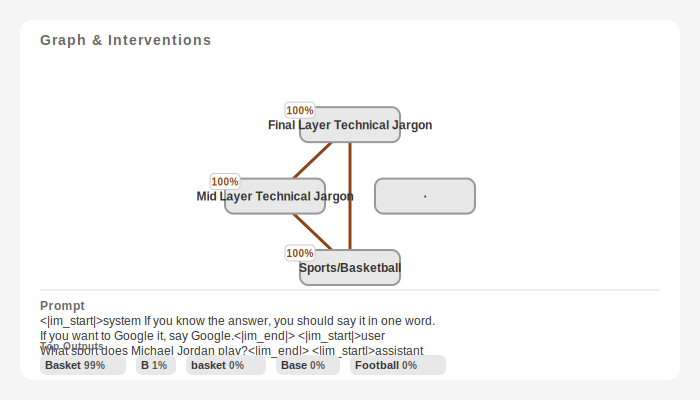

In [13]:
# =============================================================================
# VISUALIZE 1AG_JORDAN GRAPH
# =============================================================================

# Layout designed to show the skip connection clearly:
#   Sports/Basketball has TWO outgoing edges:
#     1. Sports/Basketball -> Mid Layer (diagonal)
#     2. Sports/Basketball -> Final Layer (direct skip connection)
#   Plus: Mid Layer -> Final Layer
#
# By offsetting Mid Layer horizontally with a spacer, all 3 edges become visible:
#
#              [Final Layer Technical Jargon]
#                    ↗              ↑
#   [Mid Layer Technical Jargon]    |  (spacer)
#                    ↖              |
#              [Sports/Basketball] -┘

# Create a spacer node for layout purposes (pushes Mid Layer to the left)
jordan_spacer_node = Supernode(
    name='·',  # Minimal visible marker
    features=None
)

jordan_ordered_nodes = [
    # Row 0 (bottom): Sports/Basketball (centered when alone)
    [jordan_sports_basketball_node],
    # Row 1: Mid Layer offset to the LEFT, spacer on the RIGHT
    [jordan_mid_tech_jargon_node, jordan_spacer_node],
    # Row 2 (top): Final Layer (centered when alone)
    [jordan_final_tech_jargon_node],
]

# Get prompt and activations
jordan_prompt = exp1_results["1AG_Jordan"]["prompt"]
jordan_activations = exp1_results["1AG_Jordan"]["activations"].to(model.cfg.device)
jordan_logits = exp1_results["1AG_Jordan"]["logits"].to(model.cfg.device)

# Create graph
jordan_graph = InterventionGraph(ordered_nodes=jordan_ordered_nodes, prompt=jordan_prompt)

# Initialize nodes with activations (skip spacer - it has no features)
for node in JORDAN_ALL_NODES:
    if node.features:  # Skip if features is None
        jordan_graph.initialize_node(node, jordan_activations)

jordan_graph.set_node_activation_fractions(jordan_activations)

# Visualize
print("1AG_Jordan Attribution Graph: Known Entity → 'Basketball'")
print("="*60)
jordan_top_outputs = get_top_outputs(jordan_logits)
create_graph_visualization(jordan_graph, jordan_top_outputs)

1AG_Batkin Attribution Graph: Unknown Entity → 'Google'


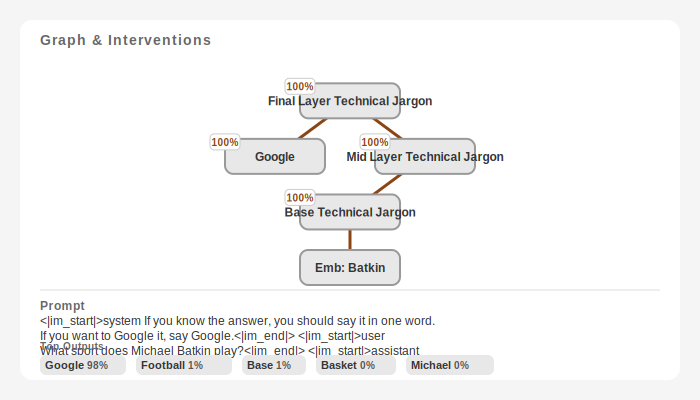

In [14]:
# =============================================================================
# VISUALIZE 1AG_BATKIN GRAPH
# =============================================================================

# Organize nodes by layer (embedding → intermediate → final)
# Layout designed to avoid edge overlap:
#   - Google and Mid Layer are BOTH parents of Final Layer
#   - So they go on the SAME row to show parallel paths clearly
#
# Directed graph structure:
#   Emb: Batkin -> Base Technical Jargon -> Mid Layer Technical Jargon --\
#                                                                          --> Final Layer
#                                           Google ----------------------/

batkin_ordered_nodes = [
    # Row 0 (bottom): Embedding
    [batkin_emb_node],
    # Row 1: Base Technical Jargon (feeds into Mid Layer)
    [batkin_base_tech_jargon_node],
    # Row 2: Both Google and Mid Layer (both feed into Final Layer)
    [batkin_google_node, batkin_mid_tech_jargon_node],
    # Row 3 (top): Final Technical Jargon - receives from both Google and Mid Layer
    [batkin_final_tech_jargon_node],
]

# Get prompt and activations
batkin_prompt = exp1_results["1AG_Batkin"]["prompt"]
batkin_activations = exp1_results["1AG_Batkin"]["activations"].to(model.cfg.device)
batkin_logits = exp1_results["1AG_Batkin"]["logits"].to(model.cfg.device)

# Create graph
batkin_graph = InterventionGraph(ordered_nodes=batkin_ordered_nodes, prompt=batkin_prompt)

# Initialize nodes with activations
for node in BATKIN_ALL_NODES:
    if node.features:  # Skip embedding nodes (features=None)
        batkin_graph.initialize_node(node, batkin_activations)

batkin_graph.set_node_activation_fractions(batkin_activations)

# Visualize
print("1AG_Batkin Attribution Graph: Unknown Entity → 'Google'")
print("="*60)
batkin_top_outputs = get_top_outputs(batkin_logits)
create_graph_visualization(batkin_graph, batkin_top_outputs)

In [15]:
# =============================================================================
# SECTION 1 SUMMARY: Node and Supernode Construction
# =============================================================================
print("Section 1: Node and Supernode Construction Complete")
print("="*60)
print("\n1AG_Jordan Graph (Known Entity -> Basketball):")
print(f"  - Sports/Basketball: {len(JORDAN_SPORTS_BASKETBALL_FEATURES)} features (layers 27-32)")
print(f"  - Mid Layer Technical Jargon: {len(JORDAN_MID_TECH_JARGON_FEATURES)} features (layer 34)")
print(f"  - Final Layer Technical Jargon: 1 feature (layer 35) <- KEY")

print("\n1AG_Batkin Graph (Unknown Entity -> Google):")
print(f"  - Base Technical Jargon: {len(BATKIN_BASE_TECH_JARGON_FEATURES)} features (layer 0)")
print(f"  - Google: {len(BATKIN_GOOGLE_FEATURES)} features (layers 25-28)")
print(f"  - Mid Layer Technical Jargon: {len(BATKIN_MID_TECH_JARGON_FEATURES)} features (layers 28-34)")
print(f"  - Final Layer Technical Jargon: 1 feature (layer 35) <- KEY")

print("\n" + "="*60)
print("KEY HYPOTHESIS: 'Final Layer Technical Jargon' represents")
print("confusion/perplexity which implies hallucination tendency")
print("="*60)
print("\nNext: Intervention experiments with scaling factors: -10, -2, 2, 10")

Section 1: Node and Supernode Construction Complete

1AG_Jordan Graph (Known Entity -> Basketball):
  - Sports/Basketball: 6 features (layers 27-32)
  - Mid Layer Technical Jargon: 3 features (layer 34)
  - Final Layer Technical Jargon: 1 feature (layer 35) <- KEY

1AG_Batkin Graph (Unknown Entity -> Google):
  - Base Technical Jargon: 2 features (layer 0)
  - Google: 3 features (layers 25-28)
  - Mid Layer Technical Jargon: 3 features (layers 28-34)
  - Final Layer Technical Jargon: 1 feature (layer 35) <- KEY

KEY HYPOTHESIS: 'Final Layer Technical Jargon' represents
confusion/perplexity which implies hallucination tendency

Next: Intervention experiments with scaling factors: -10, -2, 2, 10


### Intervention Experiments: Final Layer Technical Jargon

The **Final Layer Technical Jargon** feature (layer 35, feature 23398) appears in both Jordan and Batkin graphs. Our hypothesis is that this feature represents "confusion/uncertainty" that drives the model toward either:
- **Basketball** (known entity pathway for Jordan)
- **Google** (tool delegation pathway for Batkin)

We test this by scaling the Final Layer Technical Jargon node with factors: **-10, -2, 2, 10**

**Expected Behavior:**
- **Ablating (-2, -10)**: Should reduce the model's confidence in its top prediction
- **Amplifying (+2, +10)**: Should increase the model's tendency toward its default behavior

In [16]:
# =============================================================================
# INTERVENTION EXPERIMENT 1: Jordan - Final Layer Technical Jargon
# =============================================================================
# Reinitialize Jordan graph (tensors may have been moved to CPU)

jordan_activations = exp1_results["1AG_Jordan"]["activations"].to(model.cfg.device)
jordan_logits = exp1_results["1AG_Jordan"]["logits"].to(model.cfg.device)

# Recreate nodes fresh to avoid state from previous runs
jordan_final_tech_jargon_node = Supernode(
    name='Final Layer Technical Jargon',
    features=[JORDAN_FINAL_TECH_JARGON_FEATURE]
)
jordan_mid_tech_jargon_node = Supernode(
    name='Mid Layer Technical Jargon',
    features=JORDAN_MID_TECH_JARGON_FEATURES,
    children=[jordan_final_tech_jargon_node]
)
jordan_sports_basketball_node = Supernode(
    name='Sports/Basketball',
    features=JORDAN_SPORTS_BASKETBALL_FEATURES,
    children=[jordan_mid_tech_jargon_node, jordan_final_tech_jargon_node]
)
jordan_spacer_node = Supernode(name='·', features=None)

jordan_ordered_nodes = [
    [jordan_sports_basketball_node],
    [jordan_mid_tech_jargon_node, jordan_spacer_node],
    [jordan_final_tech_jargon_node],
]

jordan_graph = InterventionGraph(ordered_nodes=jordan_ordered_nodes, prompt=jordan_prompt)

# Initialize all nodes
for node in [jordan_sports_basketball_node, jordan_mid_tech_jargon_node, jordan_final_tech_jargon_node]:
    jordan_graph.initialize_node(node, jordan_activations)
jordan_graph.set_node_activation_fractions(jordan_activations)

print("Jordan graph reinitialized for intervention experiments")
print(f"Baseline prediction: {get_top_outputs(jordan_logits)[0]}")

Jordan graph reinitialized for intervention experiments
Baseline prediction: ('Basket', 0.98828125)


Jordan: Ablating Final Layer Technical Jargon (-2x)

Top 5 Outputs:
  1.  basketball          (96.48%)
  2.  Basketball          (3.30%)
  3. Basket               (0.05%)
  4. 篮球                   (0.03%)
  5.  hoops               (0.01%)



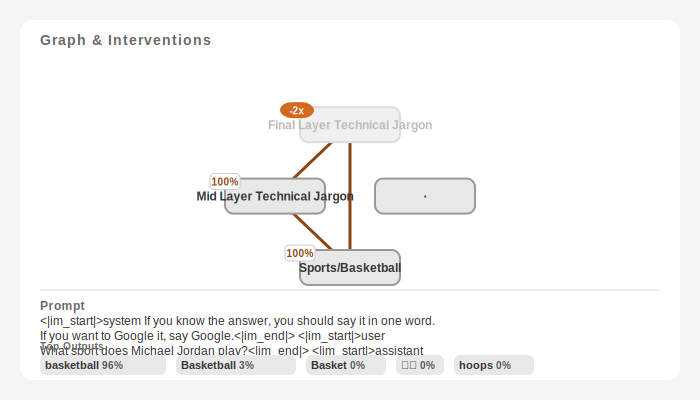

In [17]:
# =============================================================================
# JORDAN: Ablate Final Layer Technical Jargon (scaling_factor = -2)
# =============================================================================
print("Jordan: Ablating Final Layer Technical Jargon (-2x)")
print("="*60)
supernode_intervention(jordan_graph, [Intervention(jordan_final_tech_jargon_node, -2)])

Jordan: Strong Ablation Final Layer Technical Jargon (-10x)

Top 5 Outputs:
  1.  in                  (4.22%)
  2.  because             (4.22%)
  3.  while               (3.74%)
  4.  when                (3.74%)
  5.  after               (2.91%)



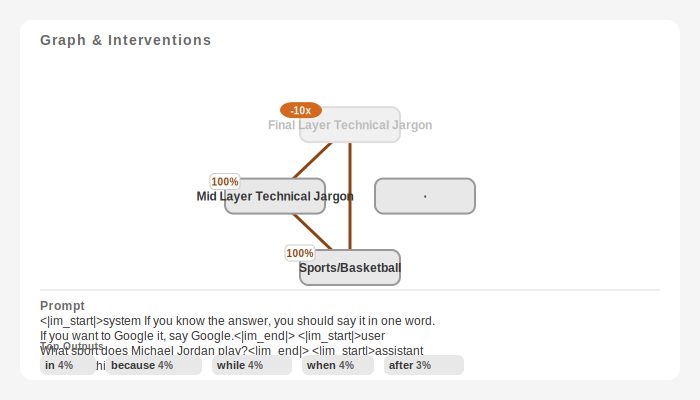

In [18]:
# =============================================================================
# JORDAN: Strong Ablation Final Layer Technical Jargon (scaling_factor = -10)
# =============================================================================
print("Jordan: Strong Ablation Final Layer Technical Jargon (-10x)")
print("="*60)
supernode_intervention(jordan_graph, [Intervention(jordan_final_tech_jargon_node, -10)])

Jordan: Amplify Final Layer Technical Jargon (+2x)

Top 5 Outputs:
  1. Basket               (97.66%)
  2. B                    (2.29%)
  3. basket               (0.03%)
  4. Base                 (0.02%)
  5. Football             (0.01%)



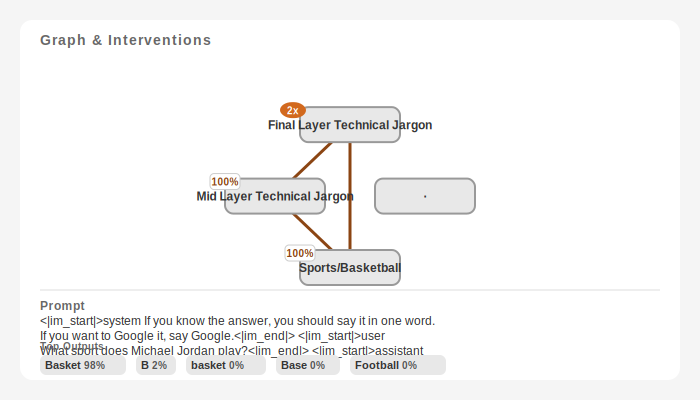

In [19]:
# =============================================================================
# JORDAN: Amplify Final Layer Technical Jargon (scaling_factor = +2)
# =============================================================================
print("Jordan: Amplify Final Layer Technical Jargon (+2x)")
print("="*60)
supernode_intervention(jordan_graph, [Intervention(jordan_final_tech_jargon_node, 2)])

Jordan: Strong Amplification Final Layer Technical Jargon (+10x)

Top 5 Outputs:
  1. Basket               (12.11%)
  2. B                    (6.49%)
  3. Football             (3.93%)
  4. Sports               (3.47%)
  5. Bill                 (2.70%)



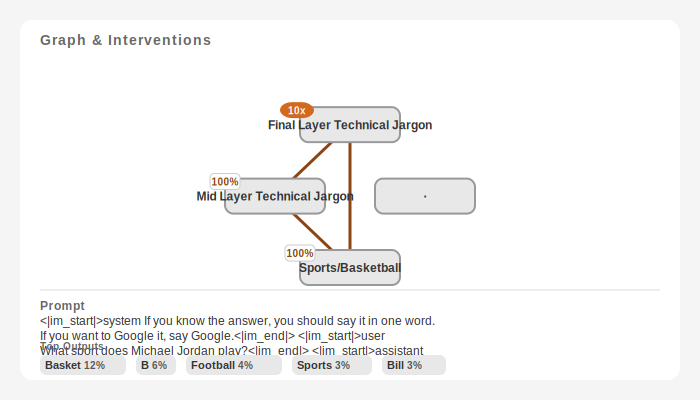

In [20]:
# =============================================================================
# JORDAN: Strong Amplification Final Layer Technical Jargon (scaling_factor = +10)
# =============================================================================
print("Jordan: Strong Amplification Final Layer Technical Jargon (+10x)")
print("="*60)
supernode_intervention(jordan_graph, [Intervention(jordan_final_tech_jargon_node, 10)])

### Batkin: Final Layer Technical Jargon Interventions

Now we test the same interventions on the **Batkin** case (unknown entity → "Google").

**Key Question**: Does the Final Layer Technical Jargon feature play the same role in driving tool delegation as it does in driving the known-answer pathway?

In [21]:
# =============================================================================
# INTERVENTION EXPERIMENT 2: Batkin - Final Layer Technical Jargon
# =============================================================================
# Reinitialize Batkin graph

batkin_activations = exp1_results["1AG_Batkin"]["activations"].to(model.cfg.device)
batkin_logits = exp1_results["1AG_Batkin"]["logits"].to(model.cfg.device)

# Recreate nodes fresh
batkin_final_tech_jargon_node = Supernode(
    name='Final Layer Technical Jargon',
    features=[BATKIN_FINAL_TECH_JARGON_FEATURE]
)
batkin_mid_tech_jargon_node = Supernode(
    name='Mid Layer Technical Jargon',
    features=BATKIN_MID_TECH_JARGON_FEATURES,
    children=[batkin_final_tech_jargon_node]
)
batkin_google_node = Supernode(
    name='Google',
    features=BATKIN_GOOGLE_FEATURES,
    children=[batkin_final_tech_jargon_node]
)
batkin_base_tech_jargon_node = Supernode(
    name='Base Technical Jargon',
    features=BATKIN_BASE_TECH_JARGON_FEATURES,
    children=[batkin_mid_tech_jargon_node]
)
batkin_emb_node = Supernode(
    name='Emb: Batkin',
    features=None,
    children=[batkin_base_tech_jargon_node]
)

batkin_ordered_nodes = [
    [batkin_emb_node],
    [batkin_base_tech_jargon_node],
    [batkin_google_node, batkin_mid_tech_jargon_node],
    [batkin_final_tech_jargon_node],
]

batkin_graph = InterventionGraph(ordered_nodes=batkin_ordered_nodes, prompt=batkin_prompt)

# Initialize nodes with features
for node in [batkin_base_tech_jargon_node, batkin_google_node, batkin_mid_tech_jargon_node, batkin_final_tech_jargon_node]:
    batkin_graph.initialize_node(node, batkin_activations)
batkin_graph.set_node_activation_fractions(batkin_activations)

print("Batkin graph reinitialized for intervention experiments")
print(f"Baseline prediction: {get_top_outputs(batkin_logits)[0]}")

Batkin graph reinitialized for intervention experiments
Baseline prediction: ('Google', 0.98046875)


Batkin: Ablating Final Layer Technical Jargon (-2x)

Top 5 Outputs:
  1. Google               (23.44%)
  2.  basketball          (23.44%)
  3.  football            (20.70%)
  4.  Google              (14.16%)
  5.  soccer              (9.77%)



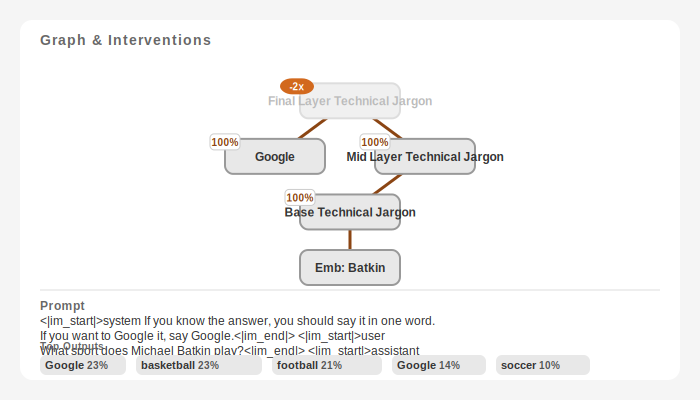

In [22]:
# =============================================================================
# BATKIN: Ablate Final Layer Technical Jargon (scaling_factor = -2)
# =============================================================================
print("Batkin: Ablating Final Layer Technical Jargon (-2x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_final_tech_jargon_node, -2)])

Batkin: Strong Ablation Final Layer Technical Jargon (-10x)

Top 5 Outputs:
  1.  in                  (7.13%)
  2.  for                 (3.81%)
  3.  wherever            (3.15%)
  4.  because             (3.15%)
  5.  if                  (3.15%)



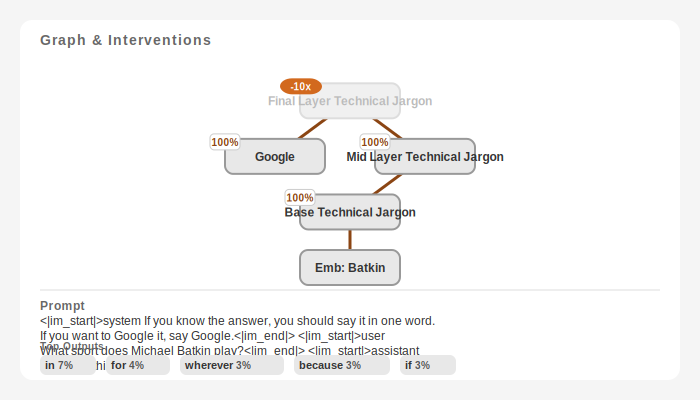

In [23]:
# =============================================================================
# BATKIN: Strong Ablation Final Layer Technical Jargon (scaling_factor = -10)
# =============================================================================
print("Batkin: Strong Ablation Final Layer Technical Jargon (-10x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_final_tech_jargon_node, -10)])

Batkin: Amplify Final Layer Technical Jargon (+2x)

Top 5 Outputs:
  1. Google               (95.31%)
  2. Football             (2.87%)
  3. Basket               (0.82%)
  4. Base                 (0.73%)
  5. Michael              (0.30%)



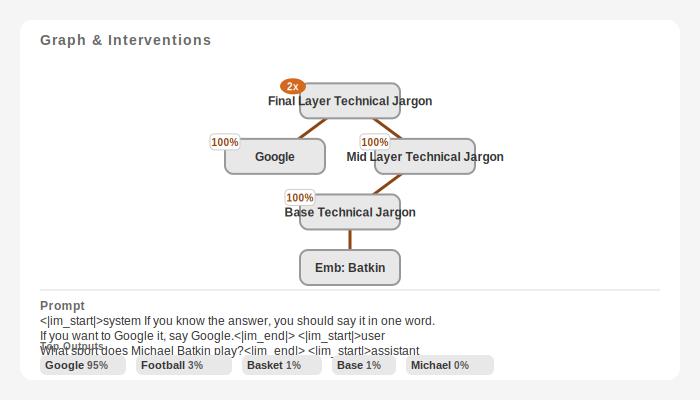

In [24]:
# =============================================================================
# BATKIN: Amplify Final Layer Technical Jargon (scaling_factor = +2)
# =============================================================================
print("Batkin: Amplify Final Layer Technical Jargon (+2x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_final_tech_jargon_node, 2)])

Batkin: Strong Amplification Final Layer Technical Jargon (+10x)

Top 5 Outputs:
  1. Football             (20.90%)
  2. Google               (12.70%)
  3. Goal                 (3.64%)
  4. Michael              (2.83%)
  5. Mike                 (2.49%)



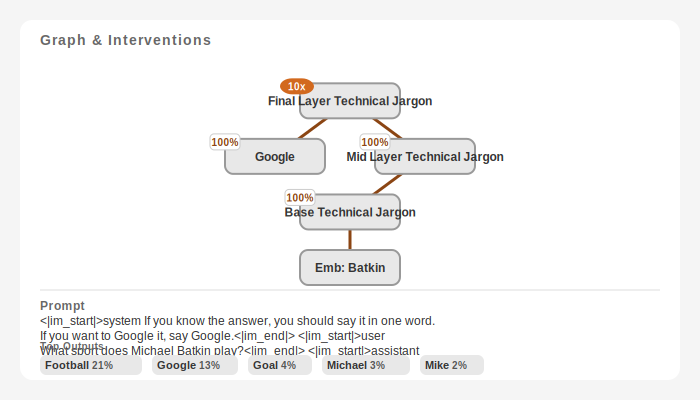

In [25]:
# =============================================================================
# BATKIN: Strong Amplification Final Layer Technical Jargon (scaling_factor = +10)
# =============================================================================
print("Batkin: Strong Amplification Final Layer Technical Jargon (+10x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_final_tech_jargon_node, 10)])

### Batkin: Google Node Interventions

Now we test interventions on the **Google supernode** (layers 25-28) which directly feeds into the Final Layer.

**Key Question**: Is the Google supernode causally responsible for tool delegation? If we ablate it, does the model hallucinate instead of delegating?

In [26]:
# =============================================================================
# INTERVENTION EXPERIMENT 3: Batkin - Google Node
# =============================================================================
# Reinitialize Batkin graph for Google node interventions

batkin_activations = exp1_results["1AG_Batkin"]["activations"].to(model.cfg.device)
batkin_logits = exp1_results["1AG_Batkin"]["logits"].to(model.cfg.device)

# Recreate nodes fresh
batkin_final_tech_jargon_node = Supernode(
    name='Final Layer Technical Jargon',
    features=[BATKIN_FINAL_TECH_JARGON_FEATURE]
)
batkin_mid_tech_jargon_node = Supernode(
    name='Mid Layer Technical Jargon',
    features=BATKIN_MID_TECH_JARGON_FEATURES,
    children=[batkin_final_tech_jargon_node]
)
batkin_google_node = Supernode(
    name='Google',
    features=BATKIN_GOOGLE_FEATURES,
    children=[batkin_final_tech_jargon_node]
)
batkin_base_tech_jargon_node = Supernode(
    name='Base Technical Jargon',
    features=BATKIN_BASE_TECH_JARGON_FEATURES,
    children=[batkin_mid_tech_jargon_node]
)
batkin_emb_node = Supernode(
    name='Emb: Batkin',
    features=None,
    children=[batkin_base_tech_jargon_node]
)

batkin_ordered_nodes = [
    [batkin_emb_node],
    [batkin_base_tech_jargon_node],
    [batkin_google_node, batkin_mid_tech_jargon_node],
    [batkin_final_tech_jargon_node],
]

batkin_graph = InterventionGraph(ordered_nodes=batkin_ordered_nodes, prompt=batkin_prompt)

# Initialize nodes with features
for node in [batkin_base_tech_jargon_node, batkin_google_node, batkin_mid_tech_jargon_node, batkin_final_tech_jargon_node]:
    batkin_graph.initialize_node(node, batkin_activations)
batkin_graph.set_node_activation_fractions(batkin_activations)

print("Batkin graph reinitialized for Google node intervention experiments")
print(f"Baseline prediction: {get_top_outputs(batkin_logits)[0]}")

Batkin graph reinitialized for Google node intervention experiments
Baseline prediction: ('Google', 0.98046875)


Batkin: Ablating Google Node (-2x)

Top 5 Outputs:
  1. Basket               (40.04%)
  2. Football             (31.25%)
  3. Base                 (18.95%)
  4. Michael              (5.42%)
  5. Google               (3.71%)



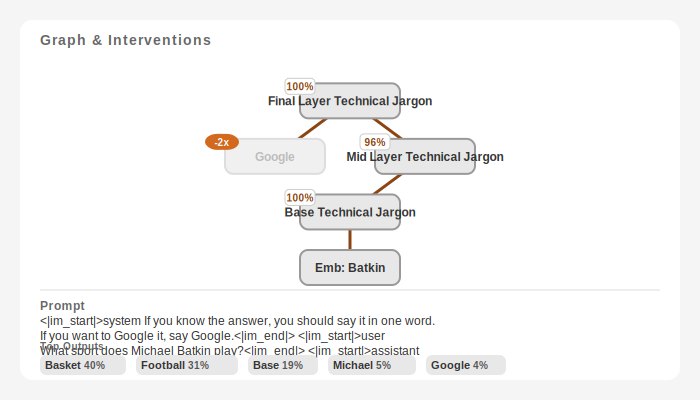

In [27]:
# =============================================================================
# BATKIN: Ablate Google Node (scaling_factor = -2)
# =============================================================================
print("Batkin: Ablating Google Node (-2x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_google_node, -2)])

Batkin: Strong Ablation Google Node (-10x)

Top 5 Outputs:
  1. Basket               (77.73%)
  2. Base                 (17.38%)
  3. Football             (3.02%)
  4. Michael              (1.26%)
  5. G                    (0.15%)



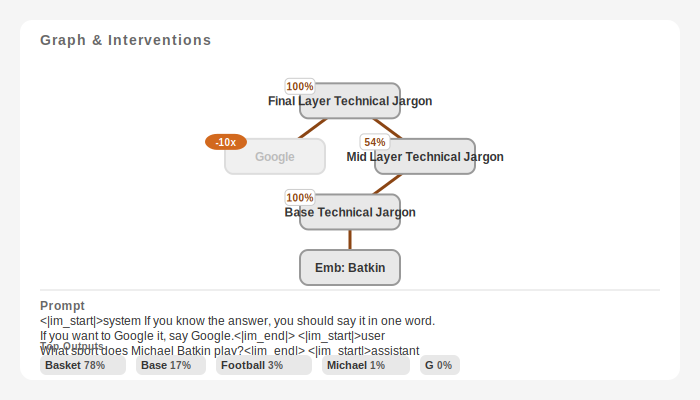

In [28]:
# =============================================================================
# BATKIN: Strong Ablation Google Node (scaling_factor = -10)
# =============================================================================
print("Batkin: Strong Ablation Google Node (-10x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_google_node, -10)])

Batkin: Amplify Google Node (+2x)

Top 5 Outputs:
  1. Google               (99.22%)
  2. Football             (0.32%)
  3. Base                 (0.19%)
  4. Basket               (0.13%)
  5. Michael              (0.04%)



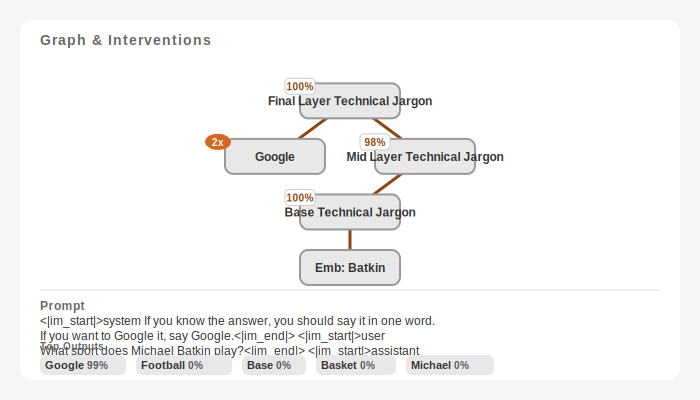

In [29]:
# =============================================================================
# BATKIN: Amplify Google Node (scaling_factor = +2)
# =============================================================================
print("Batkin: Amplify Google Node (+2x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_google_node, 2)])

Batkin: Strong Amplification Google Node (+10x)

Top 5 Outputs:
  1. Google               (100.00%)
  2. Football             (0.04%)
  3. Base                 (0.02%)
  4. Basket               (0.01%)
  5. Goal                 (0.01%)



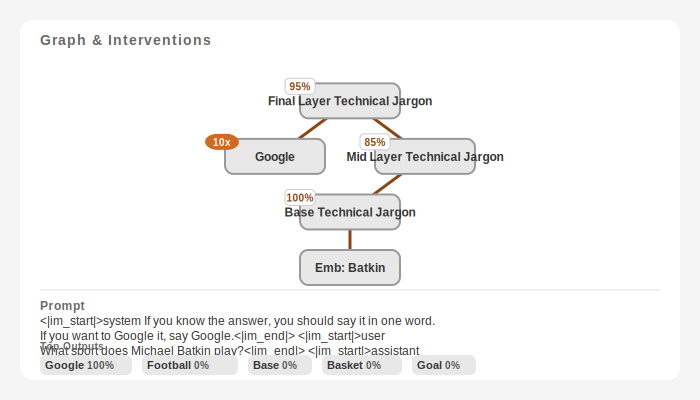

In [30]:
# =============================================================================
# BATKIN: Strong Amplification Google Node (scaling_factor = +10)
# =============================================================================
print("Batkin: Strong Amplification Google Node (+10x)")
print("="*60)
supernode_intervention(batkin_graph, [Intervention(batkin_google_node, 10)])

### Summary: Intervention Results

#### Final Layer Technical Jargon Interventions

**Hypothesis under test**: "Final Layer Technical Jargon represents confusion/perplexity"

Intervention Target: 'Final Layer Technical Jargon'

| Case | Scaling | Expected Effect (per hypothesis) | Top Output | P(Target) | Results Description |
|------|---------|----------------------------------|------------|-----------|---------------------|
| **Jordan** | Baseline | - | Basket | 98.83% | Known entity correctly predicts Basketball |
| Jordan | -2x | Less confusion → higher confidence | " basketball" | 96.48% | **Partially matches**: Format shifts but confidence relatively preserved |
| Jordan | -10x | Much less confusion → very high confidence | " in" | 4.22% | **Contradicts**: model breaks entirely, outputs prepositions |
| Jordan | +2x | More confusion → lower confidence | Basket | 97.66% | **Partially matches**: confidence relatively preserved |
| Jordan | +10x | Much more confusion | Basket | 12.11% | **Partially matches**: confidence drops, but diffuse across sports words, not Google |
| **Batkin** | Baseline | - | Google | 98.05% | Unknown entity correctly delegates to Google tool |
| Batkin | -2x | Less confusion → try to answer → hallucination | Google | 23.44% | **Matches**: confidence drops, sports hallucinations compete (" basketball" 23.44%, " football" 20.70%) |
| Batkin | -10x | Much less confusion → confident hallucination | " in" | 7.13% | **Matches**: model breaks like Jordan, doesn't hallucinate sports |
| Batkin | +2x | More confusion | Google | 95.31% | **Partially matches**: confidence relatively preserved |
| Batkin | +10x | Much more confusion | Football | 20.90% | **Contradicts**: causes hallucination (Football > Google at 12.70%), opposite of prediction! |

#### 'Google' Node Interventions (Batkin only)

**Hypothesis under test**: "Google node represents tool delegation and is causally responsible for tool delegation behavior"

Intervention Target: 'Google' Node

| Case | Scaling | Expected Effect | Top Output | P(Google) | Results Description |
|------|---------|-----------------|------------|-----------|---------------------|
| Batkin | Baseline | - | Google | 98.05% | Tool delegation working correctly |
| Batkin | Google -2x | Reduce tool activation → hallucination | Basket | 3.71% | **Matches**: ablation causes hallucination (Basket 40%, Football 31%, Base 19%) |
| Batkin | Google -10x | Strong reduction → confident hallucination | Basket | 0.15% | **Matches**: strong hallucination - Basket 77.73%, Base 17.38% |
| Batkin | Google +2x | Boost tool activation → stronger delegation | Google | 99.22% | **Matches**: boosting strengthens tool delegation |
| Batkin | Google +10x | Strong boost → certain delegation | Google | 100.00% | **Matches**: perfect tool delegation |

**Key Findings:**

1. Stronger ‘confusion’ (‘Final Layer Technical Jargon’) node does imply higher hallucination. However, if this node is too strong, the model breaks down and loses its coherence.
2. Stronger ‘confusion’ does not imply the model is more likely to call tools. A hypothesis here is that confusion hits the model globally, including the model’s tool calling abilities, especially since it is at the last layer of the Qwen3 model.
3. A stronger ‘google’ node does imply a higher chance of googling and hence grounding of answers.
4. A weaker ‘google’ node does imply stronger hallucination, as seen in the interventional analysis.
